In [23]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.utils import np_utils
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout, Activation, Bidirectional, Reshape, Input
from tensorflow.keras.models import Sequential, Model

from music21 import converter, instrument, note, chord, stream
import glob

from keras.utils import np_utils

FONTSIZE=18
plt.rcParams['figure.figsize']=(10,6)
plt.rcParams['font.size']=FONTSIZE

# Here we're going to use data where we've assumed a constant offset in notes
# I think the big improvement in quality of generated music will come when we allow for uneven spacing

In [3]:
# Load in training data from Final Fantasy soundtracks

fp = open('../LSTM/training_data_final_fantasy.pkl', "rb")
training_data = pickle.load(fp)
fp.close()

fp=open('../LSTM/note_to_int_final_fantasy.pkl','rb')
note_to_int=pickle.load(fp)
fp.close()

In [4]:
print(training_data.keys())
print(training_data['ins_train'].shape)
print(training_data['outs_train'].shape)
print(training_data['ins_validation'].shape)
print(training_data['outs_validation'].shape)
n_notes=training_data['outs_train'].shape[1]
print(n_notes)

dict_keys(['ins_train', 'outs_train', 'ins_validation', 'outs_validation'])
(25229, 100, 1)
(25229, 345)
(5295, 100, 1)
(5295, 345)
345


In [5]:
print(note_to_int)

{'3.7.8': 0, '7.8.10': 1, '1.5.8': 2, '5.9.0': 3, '1.4.7.10': 4, '7.9.2': 5, '2.7': 6, 'G3': 7, '11.3': 8, 'B4': 9, '2.3.7': 10, 'C#3': 11, '10.0.5': 12, '5.7.10.1': 13, 'G#5': 14, '1.4.7': 15, '7.11': 16, '0.6': 17, '0.4.8': 18, '6.9.0.2': 19, 'B5': 20, 'G7': 21, 'E5': 22, '0.3.5': 23, '1.4.8': 24, '11.3.4': 25, '9.11.0.4': 26, '7.8.10.0.3': 27, '8.0.1': 28, 'G2': 29, '9.10': 30, '3.5.8': 31, '4.10': 32, '10.0.3.5': 33, '7.10.1.3': 34, '1.5.6': 35, '4.7': 36, '1.3.5.8': 37, '3.5.7.10.0': 38, '3.5.7.8': 39, '7.8.10.1': 40, '5': 41, '9.2': 42, '0.4': 43, '2.5.7.9': 44, 'A6': 45, '0': 46, '5.8': 47, 'B6': 48, '0.3.6.8': 49, 'C#4': 50, '11.2': 51, '0.2.4': 52, '4.7.10': 53, '11.2.4.6': 54, '0.3': 55, '6.7': 56, 'F#3': 57, '11.1.5': 58, '2.4.5.9': 59, '0.4.7': 60, '0.1.5.8': 61, '3.5.8.11': 62, '2.4.7.9': 63, '2.8': 64, '1.5.7': 65, '9.10.2.5': 66, '11.0': 67, '7.10.1.2': 68, '2.4': 69, '6.7.11': 70, '5.7.0': 71, '5.8.11': 72, '2.5': 73, '10.0.2.5.7': 74, '6.9.1': 75, '7.11.0.2': 76, '1.3.

In [6]:
int_to_note={}
for note_temp,integer in note_to_int.items():
    int_to_note[integer]=note_temp
print(int_to_note)

{0: '3.7.8', 1: '7.8.10', 2: '1.5.8', 3: '5.9.0', 4: '1.4.7.10', 5: '7.9.2', 6: '2.7', 7: 'G3', 8: '11.3', 9: 'B4', 10: '2.3.7', 11: 'C#3', 12: '10.0.5', 13: '5.7.10.1', 14: 'G#5', 15: '1.4.7', 16: '7.11', 17: '0.6', 18: '0.4.8', 19: '6.9.0.2', 20: 'B5', 21: 'G7', 22: 'E5', 23: '0.3.5', 24: '1.4.8', 25: '11.3.4', 26: '9.11.0.4', 27: '7.8.10.0.3', 28: '8.0.1', 29: 'G2', 30: '9.10', 31: '3.5.8', 32: '4.10', 33: '10.0.3.5', 34: '7.10.1.3', 35: '1.5.6', 36: '4.7', 37: '1.3.5.8', 38: '3.5.7.10.0', 39: '3.5.7.8', 40: '7.8.10.1', 41: '5', 42: '9.2', 43: '0.4', 44: '2.5.7.9', 45: 'A6', 46: '0', 47: '5.8', 48: 'B6', 49: '0.3.6.8', 50: 'C#4', 51: '11.2', 52: '0.2.4', 53: '4.7.10', 54: '11.2.4.6', 55: '0.3', 56: '6.7', 57: 'F#3', 58: '11.1.5', 59: '2.4.5.9', 60: '0.4.7', 61: '0.1.5.8', 62: '3.5.8.11', 63: '2.4.7.9', 64: '2.8', 65: '1.5.7', 66: '9.10.2.5', 67: '11.0', 68: '7.10.1.2', 69: '2.4', 70: '6.7.11', 71: '5.7.0', 72: '5.8.11', 73: '2.5', 74: '10.0.2.5.7', 75: '6.9.1', 76: '7.11.0.2', 77: '

In [7]:
print(training_data['ins_train'][0,:,0])

[0.46666667 0.50144928 0.94202899 0.26666667 0.00869565 0.94202899
 0.23478261 0.25507246 0.94202899 0.26666667 0.00869565 0.94202899
 0.46666667 0.3826087  0.94202899 0.39130435 0.60869565 0.46666667
 0.50144928 0.94202899 0.26666667 0.00869565 0.94202899 0.23478261
 0.25507246 0.94202899 0.26666667 0.00869565 0.94202899 0.46666667
 0.3826087  0.94202899 0.39130435 0.60869565 0.46666667 0.50144928
 0.94202899 0.26666667 0.00869565 0.94202899 0.23478261 0.25507246
 0.94202899 0.26666667 0.00869565 0.94202899 0.46666667 0.3826087
 0.94202899 0.39130435 0.60869565 0.46666667 0.50144928 0.94202899
 0.26666667 0.00869565 0.94202899 0.23478261 0.25507246 0.94202899
 0.26666667 0.00869565 0.94202899 0.46666667 0.3826087  0.94202899
 0.39130435 0.60869565 0.12173913 0.88115942 0.46666667 0.88115942
 0.0173913  0.88115942 0.88115942 0.91884058 0.88115942 0.88115942
 0.0173913  0.88115942 0.91884058 0.87536232 0.88115942 0.12173913
 0.91884058 0.46666667 0.91884058 0.0173913  0.88115942 0.91884

In [8]:
def convert_to_MIDI(seq):
    '''
    takes in a sequence of floats from training_data, converts to MIDI ready notes
    '''
    
    seq_ints=[int(i*float(n_notes)) for i in seq]
    
    #first convert ints to notes
    notes=[]
    for i in seq_ints:
        notes.append(int_to_note[i])
        
    output_notes=[]
        
    offset=0
    for pattern in notes:
        if ('.' in pattern) or pattern.isdigit():
            #pattern is a chord
            notes_in_chord = pattern.split('.')
            notes_tmp=[]
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes_tmp.append(new_note)
            new_chord = chord.Chord(notes_tmp)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            #pattern is a note
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
            
        # increase offset each iteration so that notes do not stack
        offset += 0.5
        
    return output_notes
output_notes=convert_to_MIDI(training_data['ins_train'][0,:,0])
output_notes2=convert_to_MIDI(training_data['ins_validation'][0,:,0])

In [36]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output.mid')

midi_stream=stream.Stream(output_notes2)
midi_stream.write('midi',fp='test_output2.mid')

'test_output2.mid'

# So our generator needs to produce sequences of 100 notes
# Our discriminator is an LSTM



In [47]:
def build_discriminator():

    model=Sequential()
    model.add(LSTM(512,input_shape=(100,1),return_sequences=True))
    model.add(Bidirectional(LSTM(512)))
    model.add(Dense(512,activation='elu'))
    model.add(Dense(256,activation='elu'))
    model.add(Dense(1,activation='sigmoid'))
    print(model.summary())
    seq = Input(shape=(100,1))
    validity = model(seq)
    
    return Model(seq,validity)

def build_generator():
    
    model=Sequential()
    model.add(Dense(256,input_dim=1000,activation='elu'))
    model.add(Dense(512,activation='elu'))
    model.add(Dense(1024,activation='elu'))
    model.add(Dense(100,activation='sigmoid'))
    model.add(Reshape((100,1)))
    print(model.summary())
    
    noise= Input(shape=(1000,))
    seq=model(noise)
    
    return Model(noise,seq)

def build_combined():
    
        # Build and compile the discriminator
        discriminator =build_discriminator()
        lrate=0.001
        opt=tf.keras.optimizers.Adam(lr=lrate,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)
        discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Build the generator
        generator = build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(1000,))
        generated_seq = generator(z)

        # For the combined model we will only train the generator
        discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        combined = Model(z, validity)
        combined.compile(loss='binary_crossentropy', optimizer=opt)
        
        return combined

In [39]:
print(training_data.keys())
print(training_data['ins_train'].shape)
print(training_data['outs_train'].shape)
print(training_data['ins_validation'].shape)
print(training_data['outs_validation'].shape)
n_notes=training_data['outs_train'].shape[1]
print(n_notes)

dict_keys(['ins_train', 'outs_train', 'ins_validation', 'outs_validation'])
(25229, 100, 1)
(25229, 345)
(5295, 100, 1)
(5295, 345)
345


In [57]:
ins_train=training_data['ins_train']
outs_train=training_data['outs_train']
ins_validation=training_data['ins_validation']
outs_validation=training_data['outs_validation']

batch_size=64
latent_dim=1000

real=np.ones((batch_size,1))
fake=np.zeros((batch_size,1))

generator=build_generator()
discriminator=build_discriminator()
lrate=0.001
opt=tf.keras.optimizers.Adam(lr=lrate,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
combined=build_combined()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 256)               256256    
_________________________________________________________________
dense_134 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_135 (Dense)            (None, 1024)              525312    
_________________________________________________________________
dense_136 (Dense)            (None, 100)               102500    
_________________________________________________________________
reshape_22 (Reshape)         (None, 100, 1)            0         
Total params: 1,015,652
Trainable params: 1,015,652
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_39"
_________________________________________________________________
Layer (type)   

In [58]:
disc_loss=[]
gen_loss=[]
sample_interval=10

for epoch in range(1000):
    
    #grab random training indices
    idx = np.random.randint(0, ins_train.shape[0], batch_size)
    real_seqs = ins_train[idx]
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_seqs = generator.predict(noise) #fake sequence of notes produced by the generator
    
    d_loss_real = discriminator.train_on_batch(real_seqs, real)
    d_loss_fake = discriminator.train_on_batch(gen_seqs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    #Training the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, real)
    
    # Print the progress and save into loss lists
    if epoch % sample_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        disc_loss.append(d_loss[0])
        gen_loss.append(g_loss)
    



0 [D loss: 1.016529, acc.: 14.06%] [G loss: 0.689415]
10 [D loss: 0.694875, acc.: 50.78%] [G loss: 0.683187]
20 [D loss: 0.693937, acc.: 50.00%] [G loss: 0.683075]
30 [D loss: 0.692175, acc.: 58.59%] [G loss: 0.683071]
40 [D loss: 0.693408, acc.: 60.16%] [G loss: 0.683071]
50 [D loss: 0.693149, acc.: 64.06%] [G loss: 0.683071]
60 [D loss: 0.694015, acc.: 57.81%] [G loss: 0.683094]
70 [D loss: 0.688681, acc.: 64.84%] [G loss: 0.683071]
80 [D loss: 1.116877, acc.: 0.00%] [G loss: 0.683074]
90 [D loss: 0.789413, acc.: 0.00%] [G loss: 0.683141]
100 [D loss: 0.753666, acc.: 0.00%] [G loss: 0.683291]
110 [D loss: 0.742123, acc.: 0.00%] [G loss: 0.683519]
120 [D loss: 0.734600, acc.: 0.00%] [G loss: 0.683271]
130 [D loss: 0.729589, acc.: 0.78%] [G loss: 0.683276]
140 [D loss: 0.726416, acc.: 0.78%] [G loss: 0.683217]
150 [D loss: 0.713290, acc.: 46.09%] [G loss: 0.683102]
160 [D loss: 0.737704, acc.: 5.47%] [G loss: 0.683072]
170 [D loss: 0.727519, acc.: 0.78%] [G loss: 0.683281]
180 [D loss:

Text(0, 0.5, 'Loss')

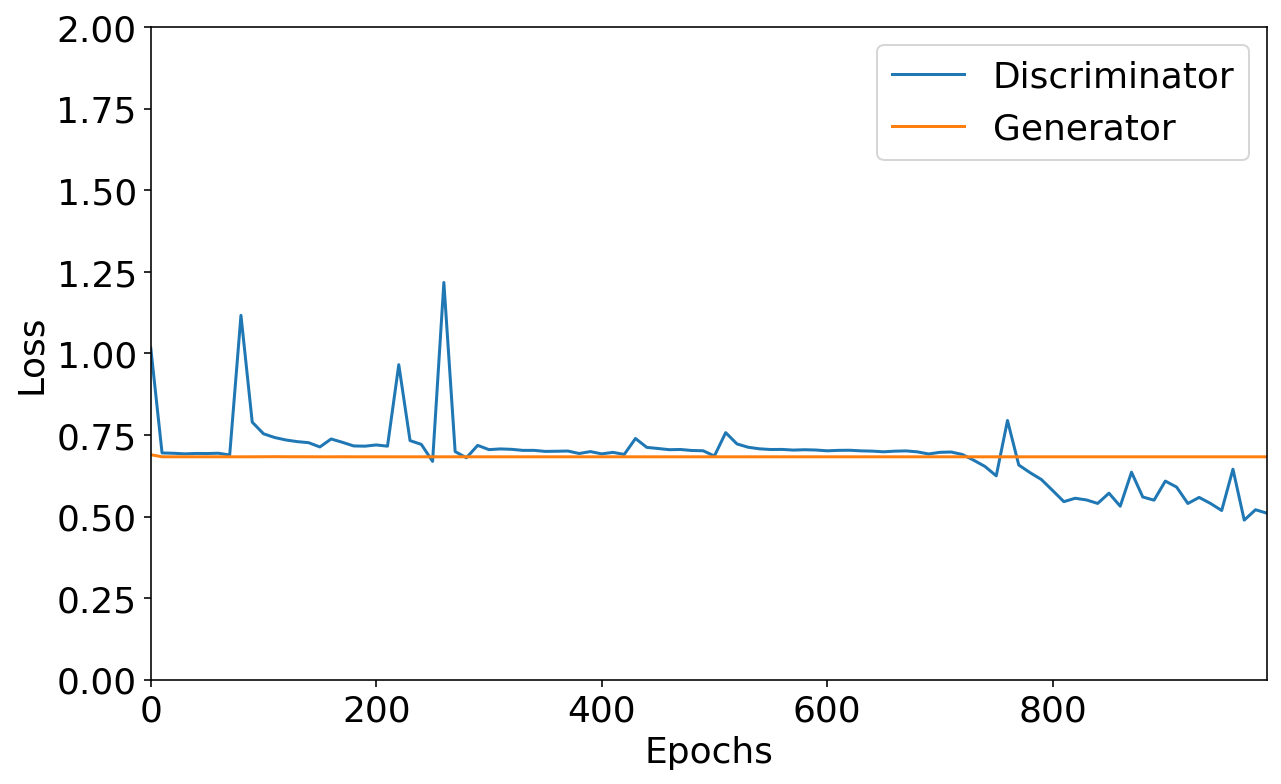

In [65]:
epochs=np.arange(len(disc_loss))*sample_interval

plt.axis([0,max(epochs),0,2])
plt.plot(epochs,disc_loss,label='Discriminator')
plt.plot(epochs,gen_loss,label='Generator')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [66]:
disc_loss=[]
gen_loss=[]
sample_interval=10

for epoch in range(1000):
    
    #grab random training indices
    idx = np.random.randint(0, ins_train.shape[0], batch_size)
    real_seqs = ins_train[idx]
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_seqs = generator.predict(noise) #fake sequence of notes produced by the generator
    
    d_loss_real = discriminator.train_on_batch(real_seqs, real)
    d_loss_fake = discriminator.train_on_batch(gen_seqs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    #Training the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, real)
    
    # Print the progress and save into loss lists
    if epoch % sample_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        disc_loss.append(d_loss[0])
        gen_loss.append(g_loss)

0 [D loss: 0.533066, acc.: 74.22%] [G loss: 0.683071]
10 [D loss: 0.575469, acc.: 71.09%] [G loss: 0.683071]
20 [D loss: 0.516939, acc.: 71.88%] [G loss: 0.683071]
30 [D loss: 0.545201, acc.: 74.22%] [G loss: 0.683071]
40 [D loss: 0.584226, acc.: 71.09%] [G loss: 0.683071]
50 [D loss: 0.567981, acc.: 70.31%] [G loss: 0.683071]
60 [D loss: 0.581974, acc.: 70.31%] [G loss: 0.683071]
70 [D loss: 0.481274, acc.: 76.56%] [G loss: 0.683071]
80 [D loss: 0.577907, acc.: 72.66%] [G loss: 0.683071]
90 [D loss: 0.519969, acc.: 72.66%] [G loss: 0.683071]
100 [D loss: 0.533945, acc.: 71.09%] [G loss: 0.683071]
110 [D loss: 0.550133, acc.: 68.75%] [G loss: 0.683071]
120 [D loss: 0.509609, acc.: 78.91%] [G loss: 0.683071]
130 [D loss: 0.522694, acc.: 71.09%] [G loss: 0.683071]
140 [D loss: 0.473230, acc.: 79.69%] [G loss: 0.683071]
150 [D loss: 0.476044, acc.: 79.69%] [G loss: 0.683071]
160 [D loss: 0.570592, acc.: 71.09%] [G loss: 0.683071]
170 [D loss: 0.521167, acc.: 73.44%] [G loss: 0.683071]
180

In [ ]:
for epoch in range(1000):
    
    #grab random training indices
    idx = np.random.randint(0, ins_train.shape[0], batch_size)
    real_seqs = ins_train[idx]
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_seqs = generator.predict(noise) #fake sequence of notes produced by the generator
    
    d_loss_real = discriminator.train_on_batch(real_seqs, real)
    d_loss_fake = discriminator.train_on_batch(gen_seqs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    #Training the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, real)
    
    # Print the progress and save into loss lists
    if epoch % sample_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        disc_loss.append(d_loss[0])
        gen_loss.append(g_loss)

Text(0, 0.5, 'Loss')

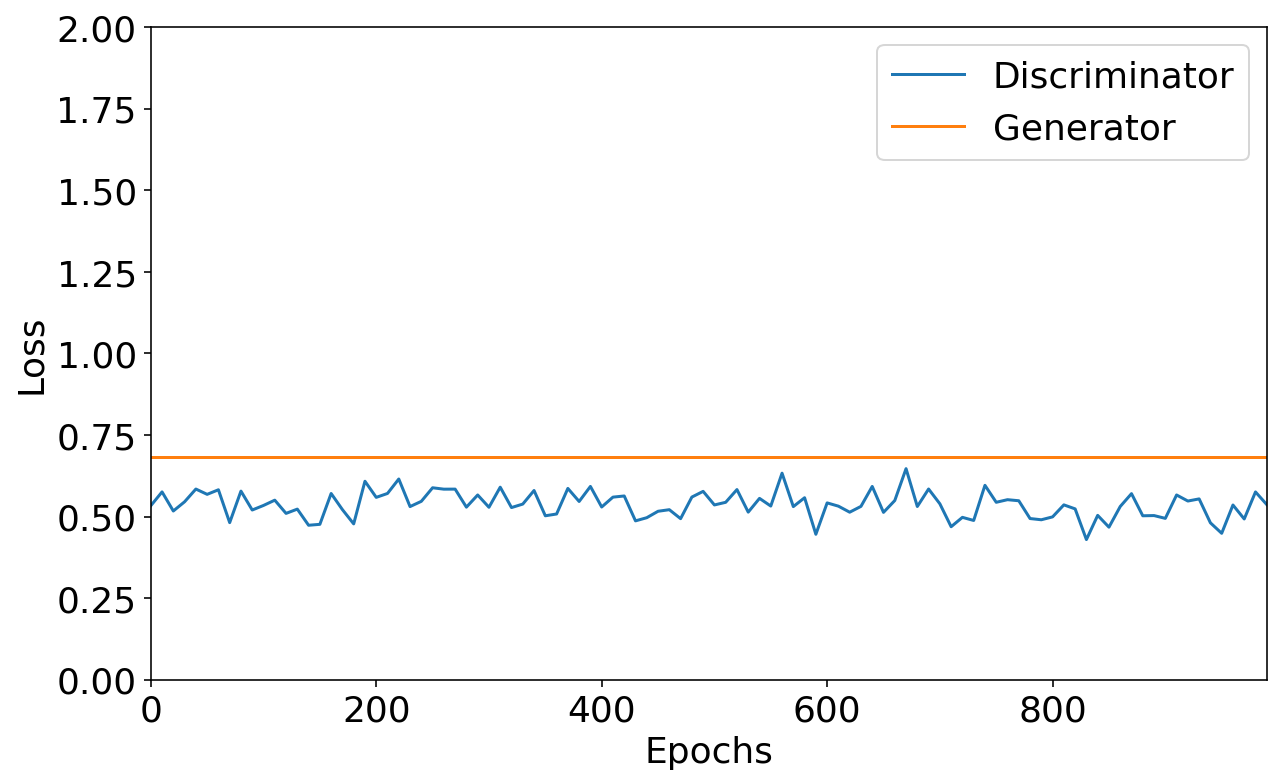

In [67]:
epochs=np.arange(len(disc_loss))*sample_interval

plt.axis([0,max(epochs),0,2])
plt.plot(epochs,disc_loss,label='Discriminator')
plt.plot(epochs,gen_loss,label='Generator')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [68]:
# Produce a midi

noise = np.random.normal(0, 1, (batch_size, latent_dim))
gen_seqs = generator.predict(noise)
print(gen_seqs.shape)

(64, 100, 1)


In [69]:
gan_output=convert_to_MIDI(gen_seqs[0,:,0])
midi_stream = stream.Stream(gan_output)
midi_stream.write('midi', fp='gan_output2000_1.mid')

'gan_output2000_1.mid'

In [70]:
gan_output=convert_to_MIDI(gen_seqs[1,:,0])
midi_stream = stream.Stream(gan_output)
midi_stream.write('midi', fp='gan_output2000_2.mid')

'gan_output2000_2.mid'